In [12]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import numpy as np
import tensorflow as tf
from joblib import load,dump
from rdkit import Chem
import pandas as pd

from deepchem.models import GraphConvModel, MPNNModel
import deepchem as dc
from deepchem.molnet.preset_hyper_parameters import hps
from copy import deepcopy
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
%matplotlib inline
#os.environ.setdefault('DEEPCHEM_DATA_DIR', os.popen('pwd').read().strip())

In [13]:
dc.__version__

'2.1.1'

In [14]:
seed = 777
np.random.seed(seed)
tf.set_random_seed(seed)

In [15]:
def featurize_data(tasks, smiles_col, featurizer, dataset_file, normalize = True):
    loader = dc.data.CSVLoader(tasks=tasks, smiles_field=smiles_col, featurizer=featurizer)
    dataset = loader.featurize(dataset_file, shard_size=8192)
    move_mean = True
    if normalize:
        transformers = [dc.trans.NormalizationTransformer(
            transform_y=True, dataset=dataset, move_mean=move_mean)]
    else:
        transformers = []
    for transformer in transformers:
        dataset = transformer.transform(dataset)
    return dataset, transformers

In [16]:
featurizer = dc.feat.graph_features.WeaveFeaturizer()
metric = dc.metrics.Metric(dc.metrics.rms_score, np.mean)

# use the same dataset as MolMapNet and attentivFP

In [17]:
tasks = ['measured log solubility in mols per litre']
smiles_col = 'smiles'

# tasks, delaney_datasets, transformers = dc.molnet.load_delaney(featurizer='Weave', split='random')
# train_dataset, valid_dataset, test_dataset = delaney_datasets
train_dataset, transformers =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../train.csv')

valid_dataset, _ =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../valid.csv')

test_dataset, _ =  featurize_data(tasks = tasks, smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../test.csv')

etc_dataset, _ =  featurize_data(tasks = ['Exp_LogS'], smiles_col = smiles_col, 
                                           featurizer =featurizer, dataset_file='../etc.csv')


Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../train.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 1.148 s
TIMING: dataset construction took 1.368 s
Loading dataset from disk.
TIMING: dataset construction took 0.265 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../valid.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.156 s
TIMING: dataset construction took 0.183 s
Loading dataset from disk.
TIMING: dataset construction took 0.030 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../test.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.130 s
TIMING: dataset construction took 0.149 s
Loading dataset from disk.
TIMING: dataset construction took 0.024 s
Loading dataset from disk.
Loading raw samples now.
shard_size: 8192
About to

In [18]:
# Fit trained model use best parameters
n_atom_feat = 75
n_pair_feat = 14

# Batch size of models
batch_size = 64
patience = 30

lr = 1e-5

model = dc.models.MPNNModel(
                            len(tasks),
                            n_atom_feat=n_atom_feat,
                            n_pair_feat=n_pair_feat,
                            T=3,
                            M=5,
                            batch_size=batch_size,
                            learning_rate=lr,
                            use_queue=False,
                            mode="regression")



def count_params(model):
    trainable_paras = 0
    for layer in model.layers.values():
        x = model.get_layer_variable_values(layer)
        for  i in x:
            if type(i) == np.ndarray:
                if len(i.shape) == 1:
                    trainable_paras += i.shape[0]
                else:
                    a, b = i.shape
                    trainable_paras += a*b
    return trainable_paras

In [19]:
#count_params(model)

In [20]:
## perform an early stopping strategy
best_rmse = np.inf
patience = 30
epochs = 500
model_performace = {}
wait = 0

for i in range(epochs):
    model.fit(train_dataset, nb_epoch=1, verbos = 0)
    valid_scores = model.evaluate(valid_dataset, [metric], transformers)
    valid_rmse = valid_scores.get('mean-rms_score')
    model_performace[i] = valid_rmse
    
    
    if  valid_rmse < best_rmse:
        best_rmse = valid_rmse
        print(best_rmse)
        wait = 0        
        best_train_rmse = model.evaluate(train_dataset, [metric], transformers).get('mean-rms_score')
        best_valid_rmse = model.evaluate(valid_dataset, [metric], transformers).get('mean-rms_score')        
        best_test_rmse = model.evaluate(test_dataset, [metric], transformers).get('mean-rms_score')
        best_etc_rmse = model.evaluate(etc_dataset, [metric], transformers).get('mean-rms_score')

        best_train_pred_y = list(model.predict(train_dataset, transformers).reshape(-1,))
        best_valid_pred_y = list(model.predict(valid_dataset, transformers).reshape(-1,))           
        best_test_pred_y = list(model.predict(test_dataset, transformers).reshape(-1,))                 
        best_etc_pred_y = list(model.predict(etc_dataset, transformers).reshape(-1,))             
        
        
        best_epoch = i
    else:
        wait += 1
        if wait >= patience:
            print('early stopping at best_rmse : %s...' % best_rmse)
            break

/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sxh/anaconda3/envs/my-rdkit-env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


computed_metrics: [2.0330416384636907]
2.0330416384636907
computed_metrics: [1.9917421993686013]
computed_metrics: [2.0330416381951335]
computed_metrics: [2.0199252241849046]
computed_metrics: [2.268804359002615]
computed_metrics: [1.9887151806774832]
1.9887151806774832
computed_metrics: [1.9211863053447849]
computed_metrics: [1.988715176957381]
computed_metrics: [1.958631084777008]
computed_metrics: [2.556575771606248]
computed_metrics: [1.9477059343286223]
1.9477059343286223
computed_metrics: [1.8603324880550232]
computed_metrics: [1.9477059298581263]
computed_metrics: [1.907776653578172]
computed_metrics: [2.851387951338282]
computed_metrics: [1.9034209198329102]
1.9034209198329102
computed_metrics: [1.8025551758582876]
computed_metrics: [1.9034209195736427]
computed_metrics: [1.8639723173619784]
computed_metrics: [3.0971591961433433]
computed_metrics: [1.8495659688959827]
1.8495659688959827
computed_metrics: [1.7447030240981594]
computed_metrics: [1.8495659663515884]
computed_metri

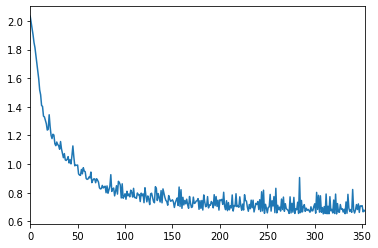

In [21]:
pd.Series(model_performace).plot()

In [22]:
final_res = {'train_rmse':best_train_rmse, 
             'valid_rmse':best_valid_rmse, 
             'test_rmse':best_test_rmse,              
             'etc_rmse':best_etc_rmse,

#              'train_pred_y':best_train_pred_y,
#              'test_pred_y':best_test_pred_y,
             'etc_pred_y':best_etc_pred_y, 


             '# trainable params': count_params(model),
             'random_seed':seed, 
             'best_epoch': best_epoch,

             'batch_size':batch_size,
             #'lr': lr,

            }

final_res

{'train_rmse': 0.4634238380008247,
 'valid_rmse': 0.6521968717781882,
 'test_rmse': 0.9402529007588152,
 'etc_rmse': 2.064877212198057,
 'etc_pred_y': [-3.3531737626161924,
  -3.2720778497986474,
  -3.1849853545287803,
  -3.2996156596381234,
  -3.4899412048019087,
  -3.196074089349315,
  -4.128616129219969,
  -4.95663064948694,
  -4.326198689024575,
  -3.4915043684760128,
  -3.3439298551215724,
  -3.8755001514020657,
  -3.524510451620362,
  -3.7818531240515476,
  -3.4600952334599606,
  -3.462854740086426,
  -3.4944666767277877,
  -3.3666449024916254,
  -3.471926720138594,
  -3.58708504969493,
  -3.775737694975253,
  -3.4218886536069397,
  -3.648070354920148,
  -3.4984290111503498,
  -3.375311753793935,
  -3.4308731040853706,
  -3.287641775281073,
  -3.3508375423020453,
  -3.2809838178511863,
  -3.6004963392076914,
  -3.5429119391044592,
  -3.073846712697422,
  -2.975833825591639,
  -3.5827673142022767,
  -4.4830470034215875,
  -2.993054082972617,
  -3.756326248437768,
  -3.374936581858